In [134]:
import numpy as np
import matplotlib.pyplot as plt

In [135]:
def maillage_carre(n: int):
    """
    Une discrétisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[.
    Le carre [0,1]x[0,1] est maille uniquement avec des triangles.
    Les conditions limites sont de type Dirichlet uniquement -> `neumann=[]`.

    Args:
        n: nombre de points par cote du care => Npts points de discretisation au total

    Returns:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements3: matrice a trois colonnes. Chaque ligne contient les indices des sommets d'un element triangle, dans le sens antihoraire.
        dirichlet: vecteur colonne des indices des sommets de la frontiere de Dirichlet.
        neumann: matrice a deux colonnes. Chaque ligne contient les indices des deux sommets d'une arete de la frontiere de Neumann. (neumann est vide sur cet exemple)
    """

    h = 1 / (n - 1)
    n_pts = n * n
    n_elm = 2 * (n - 1) * (n - 1)
    coordinates = np.zeros((n_pts, 2))
    elements3 = np.zeros((n_elm, 3), dtype=int)
    neumann = []
    dirichlet = np.zeros((4 * n - 4, 1), dtype=int)

    # Coordonnees et connectivites :
    e = -1
    p = -1
    x = np.zeros((n + 1, 1))
    x[n, 0] = 1.0

    for l in range(n + 1):
        x[l, 0] = l * h

    for j in range(n):
        for i in range(n):
            p = p + 1
            coordinates[p, 0] = x[i, 0]
            coordinates[p, 1] = x[j, 0]
            if (i != n - 1) & (j != n - 1):
                p1 = p
                p2 = p1 + 1
                p3 = p1 + n
                p4 = p2 + n
                e = e + 1
                elements3[e, 0] = p1
                elements3[e, 1] = p2
                elements3[e, 2] = p3
                e = e + 1
                elements3[e, 0] = p4
                elements3[e, 1] = p3
                elements3[e, 2] = p2

    # Liste des sommets de la frontiere de Dirichlet:
    p = -1
    for j in range(n):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * 2 - 1, n * (n - 1), n):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * n - 1, n * n - n - 1, -1):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * n - 2 * n, n - 1, -n):
        p = p + 1
        dirichlet[p, 0] = j

    return coordinates, elements3, dirichlet, neumann


In [136]:
def show(coordinates, u, title) -> None:
    """Fonction d'affichage de la solution u sur le maillage defini par elements3, coordinates.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        u: vecteur colonne de longueur egale au nombre de lignes de coordinates contenant les valeurs de la solution a afficher aux points de la discretisation.
        title: le titre de la figure

    Returns:
        None, plots a figure
    """

    ax = plt.figure().add_subplot(projection="3d")
    ax.plot_trisurf(
        coordinates[:, 0], coordinates[:, 1], u, linewidth=0.2, antialiased=True
    )
    plt.title(title)
    plt.show()

## Partie I : maillage triangulaire et conditions de Dirichlet

$$
\left\{
\begin{array}{rll}

\displaystyle -\delta u (x, y) &= f(x, y) &\text{sur } \Omega \\
\displaystyle u (x, y) &= u_d(x, y) &\text{sur } \partial\Omega_d \\
\displaystyle \frac{\partial u (x, y)}{\partial n} &= g(x, y) &\text{sur } \partial\Omega_n

\end{array}
\right.
$$


In [137]:
def f(x, y) -> np.ndarray:
    return 2 * np.pi ** 2 * np.sin(np.pi * x) * np.sin(np.pi * y)


def u_ex(x, y) -> np.ndarray:
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def u_d(x, y) -> np.ndarray:
    return np.zeros(x.shape[0])

In [138]:
# affichage d'un petit maillage
coords, elems3, dirichlet, neumann = maillage_carre(3)
print(
    f"coords = {coords}",
    f"elems3 = {elems3}",
    f"dirichlet = {dirichlet}",
    f"neumman = {neumann}",
    sep="\n\n"
)

coords = [[0.  0. ]
 [0.5 0. ]
 [1.  0. ]
 [0.  0.5]
 [0.5 0.5]
 [1.  0.5]
 [0.  1. ]
 [0.5 1. ]
 [1.  1. ]]

elems3 = [[0 1 3]
 [4 3 1]
 [1 2 4]
 [5 4 2]
 [3 4 6]
 [7 6 4]
 [4 5 7]
 [8 7 5]]

dirichlet = [[0]
 [1]
 [2]
 [5]
 [8]
 [7]
 [6]
 [3]]

neumman = []


In [139]:
def calcul_alpha(x, y) -> float:
    """Calcul du coefficient alpha.

    Args:
        x (np.array): les coordonnées x du triangle.
        y (np.array): les coordonnées y du triangle.

    Returns:
        alpha: le coefficient alpha.
    """
    mat_alpha = np.array(
        [
            [x[1] - x[0], x[2] - x[0]],
            [y[1] - y[0], y[2] - y[0]]
        ]
    )

    return np.linalg.det(mat_alpha)

$$[M^A_T]_{ij} = \displaystyle \int_T \nabla \eta_i (x, y)^\top \eta_j (x, y) \ dx \ dy$$

In [140]:
def raideur(triangle) -> np.ndarray:
    """Construction de la matrice de raideur ́elementaire relative à un ́élément triangle.

    Args:
        triangle: les coordonnées x et y des trois points formant le triangle.

    Returns:
        M: La matrice de raideur ́elementaire.
    """
    M = np.zeros((3, 3))
    x = triangle[:, 0]
    y = triangle[:, 1]

    alpha = calcul_alpha(x, y)

    # calcul de la matrice M
    for i in range(3):
        grad_eta_i = np.array(
            [
                y[(i+1)%3] - y[(i+2)%3],
                x[(i+2)%3] - x[(i+1)%3]
            ]
        )
        for j in range(3):
            grad_eta_j = np.array(
                [
                    y[(j+1)%3] - y[(j+2)%3],
                    x[(j+2)%3] - x[(j+1)%3]
                ]
            )

            M[i, j] = np.dot(grad_eta_i, grad_eta_j)

    return M / alpha / 2

# on affiche la première matrice de raideur pour vérifier
raideur(coords[elems3[0]])

array([[ 1. , -0.5, -0.5],
       [-0.5,  0.5,  0. ],
       [-0.5,  0. ,  0.5]])

In [141]:
def assemblage(coordinates, elements3) -> np.ndarray:
    """Assemblage de la matrice A dans le cas d'un maillage constitué uniquement d'éléments triangles.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements3: matrice a trois colonnes. Chaque ligne contient les indices des sommets d'un element triangle, dans le sens antihoraire.

    Returns:
        A: matrice nécéssaire à la résolution de la formulation variationnelle du problème.
    """
    Ns = len(coordinates)
    A = np.zeros((Ns, Ns))

    for triangle in elements3:
        M = raideur(coordinates[triangle])
        for i, a in enumerate(triangle):
            for j, b in enumerate(triangle):
                A[a, b] += M[i, j]
    
    return A

In [142]:
def second_membre(coordinates, elements3) -> np.ndarray:
    """Calcul le second membre.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements3: matrice a trois colonnes. Chaque ligne contient les indices des sommets d'un element triangle, dans le sens antihoraire.

    Returns:
        b: vecteur b nécéssaire à la résolution de la formulation variationnelle du problème, sans les conditions de Dirichlet.
    """
    Ns = len(coordinates)
    b = np.zeros(Ns)
    for triangle in elements3:
        coords_triangle = coordinates[triangle]
        centre = np.mean(coords_triangle, 0)
        x = coords_triangle[:, 0]
        y = coords_triangle[:, 1]

        alpha = calcul_alpha(x, y)

        # approximation pour la quadrature du second membre
        b[triangle] += alpha / 6 * f(centre[0], centre[1])

    return b

In [143]:
def calcul_Ud(coords, dirichlet) -> np.ndarray:
    """Calcul le vecteur Ud nécéssaire à l'application des conditions de Dirichlet.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        dirichlet: vecteur colonne des indices des sommets de la frontiere de Dirichlet.

    Returns:
        Ud: vecteur pour appliquer les conditions de Dirichlet.
    """
    Ns = len(coords)
    U = np.zeros(Ns)

    U[dirichlet.T] = u_d(coords[dirichlet, 0], coords[dirichlet, 1])

    return U

In [144]:
def tildage(A, b, coordinates, dirichlet):
    """Permet de retirer les parties de A et b soumis au conditions de Dirichlet, nécéssaire avant la résolution numérique.

    Args:
        A: La matrice A de la résolution numérique.
        b: Le vecteur b de la résolution numérique.
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        dirichlet: vecteur colonne des indices des sommets de la frontiere de Dirichlet.

    Returns:
        A: La matrice A de la résolution numérique tildée.
        b: Le vecteur b de la résolution numérique tildé.
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation non soumis ausx conditions de Dirichlet. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
    """
    A_tild = np.delete(A, dirichlet, 0)
    A_tild = np.delete(A_tild, dirichlet, 1)
    
    b_tild = np.delete(b, dirichlet, 0)
    
    coords_tild = np.delete(coordinates, dirichlet, 0)

    return A_tild, b_tild, coords_tild

In [145]:
def untildage(x, dirichlet, U_d) -> np.ndarray:
    """Opération inverse de la fonction tildage, place dans le vecteur x aux coordonnées de dirichlet les valeurs des conditions

    Args:
        x: le vecteur solution trouvé après résolution.
        dirichlet: vecteur colonne des indices des sommets de la frontiere de Dirichlet.
        Ud: vecteur pour appliquer les conditions de Dirichlet.

    Returns:
        x: le vecteur solution complet, avec les conditions aux bords.
    """
    x_untild = np.zeros(U_d.shape[0])
    not_dirichlet = np.setdiff1d(range(U_d.shape[0]), dirichlet)

    x_untild[dirichlet] = U_d[dirichlet]
    x_untild[not_dirichlet] = x

    return x_untild

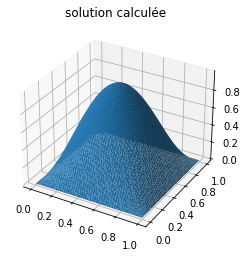

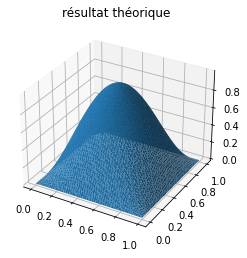

In [146]:
n = 50
coords, elems3, dirichlet, neumann = maillage_carre(n)

# calcul du premier membre de l'équation
A = assemblage(coords, elems3)

# calcul du second membre de l'équation
b = second_membre(coords, elems3)

# calcul du vecteur des conditions de dirichlet
U_d = calcul_Ud(coords, dirichlet)

# on modifie b pour vérifier les conditions 
b -= np.dot(A, U_d)

# on enlève les conditions aux bords avant résolution
A_tild, b_tild, coords_tild = tildage(A, b, coords, dirichlet)

# on résoud le système
x = np.linalg.solve(A_tild, b_tild)

# on remet les conditions aux bords
x_untild = untildage(x, dirichlet, U_d)

# on affiche le résultat
show(coords, x_untild, "solution calculée")

# on compare avec le résultat théorique exacte
show(coords, u_ex(coords[:, 0], coords[:, 1]), "résultat théorique")

## Partie II : maillage mixte et ajoût des conditions de Neumann


In [147]:
def f(x, y) -> int:
    return 1


def u_d(x, y) -> int:
    return 1


def g(x) -> int:
    return 1

In [148]:
# Création d'un maillage mixte

e3 = np.array(
    [[1, 2, 12], [2, 3, 12], [3, 4, 14], [4, 5, 14], [2, 15, 3], [3, 15, 4]]
).astype(int)

e4 = np.array(
    [
        [0, 1, 12, 11],
        [11, 12, 13, 10],
        [12, 3, 14, 13],
        [10, 13, 8, 9],
        [13, 14, 7, 8],
        [14, 5, 6, 7],
    ]
).astype(int)

dds = np.array([2, 15, 4, 6, 7, 8, 9, 10, 11, 0]).astype(int)

nns = np.array([[4, 5], [5, 6], [0, 1], [1, 2]]).astype(int)

ccs = np.array(
    [
        [0, 0],
        [1 / 3, 0],
        [16 / 30, 0],
        [2 / 3, 1 / 3],
        [1, 14 / 30],
        [1, 2 / 3],
        [1, 1],
        [2 / 3, 1],
        [1 / 3, 1],
        [0, 1],
        [0, 2 / 3],
        [0, 1 / 3],
        [1 / 3, 1 / 3],
        [1 / 3, 2 / 3],
        [2 / 3, 2 / 3],
        [1, 0],
    ]
)

In [149]:
def raideur_quadrangle(quadrangle) -> np.ndarray:
    """Construction de la matrice de raideur ́elementaire relative à un ́élément quadrangle.

    Args:
        quadrangle: les coordonnées x et y des quatres points formant le quadrangle.

    Returns:
        M: La matrice de raideur ́elementaire.
    """
    x = quadrangle[:, 0]
    y = quadrangle[:, 1]

    # calcul de la jacobienne et de son déterminant
    J_kk = np.array([[x[1] - x[0], x[3] - x[0]], [y[1] - y[0], y[3] - y[0]]])
    det_J_kk = np.linalg.det(J_kk)

    # on récupère les coefficients
    coeffs = np.linalg.inv(np.matmul(J_kk.T, J_kk))
    a = coeffs[0, 0]
    b = coeffs[0, 1]
    c = coeffs[1, 1]

    # on calcul M (on a calculé toutes les intégrales au préalable)
    M = np.array(
        [
            [2 * a + 3 * b + 2 * c, -2 * a + c, -a - 3 * b - c, a - 2 * c],
            [-2 * a + c, 2 * a - 3 * b + 2 * c, a - 2 * c, -a + 3 * b - c],
            [-a - 3 * b - c, a - 2 * c, 2 * a + 3 * b + 2 * c, -2 * a + c],
            [a - 2 * c, -a + 3 * b - c, -2 * a + c, 2 * a - 3 * b + 2 * c],
        ]
    )

    return det_J_kk / 6 * M

# on affiche la première matrice de raideur pour vérifier
raideur_quadrangle(ccs[e4[0]])

array([[ 0.66666667, -0.16666667, -0.33333333, -0.16666667],
       [-0.16666667,  0.66666667, -0.16666667, -0.33333333],
       [-0.33333333, -0.16666667,  0.66666667, -0.16666667],
       [-0.16666667, -0.33333333, -0.16666667,  0.66666667]])

In [150]:
def assemblage_quadrangle(coordinates, elements4) -> np.ndarray:
    """Assemblage de la matrice A dans le cas d'un maillage constitué uniquement d'éléments quadrangles.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements4: matrice a quatre colonnes. Chaque ligne contient les indices des sommets d'un element quadrangle, dans le sens antihoraire.

    Returns:
        A: matrice nécéssaire à la résolution de la formulation variationnelle du problème.
    """
    Ns = len(coordinates)
    A = np.zeros((Ns, Ns))

    for quadrangle in elements4:
        M = raideur_quadrangle(coordinates[quadrangle])
        for i, a in enumerate(quadrangle):
            for j, b in enumerate(quadrangle):
                A[a, b] += M[i, j]
    
    return A

In [151]:
def second_membre_quadrangle(coordinates, elements4) -> np.ndarray:
    """Calcul le second membre.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements4: matrice a quatre colonnes. Chaque ligne contient les indices des sommets d'un element quadrangle, dans le sens antihoraire.

    Returns:
        b: vecteur b nécéssaire à la résolution de la formulation variationnelle du problème, sans les conditions de Dirichlet.
    """
    Ns = len(coordinates)
    b = np.zeros(Ns)
    for quadrangle in elements4:
        coords_quadrangle = coordinates[quadrangle]
        centre = np.mean(coords_quadrangle, 0)
        x = coords_quadrangle[:, 0]
        y = coords_quadrangle[:, 1]

        alpha = calcul_alpha(x, y)

        b[quadrangle] += alpha / 4 * f(centre[0], centre[1])

    return b

In [152]:
def condition_neumann(coordinates, neumann) -> np.ndarray:
    """Calcul le vecteur nécéssaire à l'application des conditions de Neumann.

    Args:
        coordinates: matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        neumann: vecteur colonne des indices des sommets de la frontiere de Neumann.

    Returns:
        Ud: vecteur pour appliquer les conditions de Neumann.
    """
    Ns = len(coordinates)
    coeffs = np.zeros(Ns)
    for i, j in neumann:
        point1 = coordinates[i]
        point2 = coordinates[j]
        
        valeur = np.linalg.norm(point1 - point2) / 2 * g((point1 + point2) / 2)
        coeffs[i] += valeur
        coeffs[j] += valeur

    return coeffs

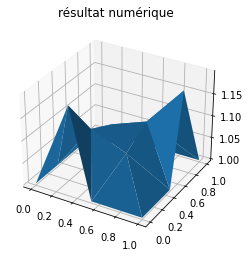

In [153]:
# calcul de premier membre de l'équation
A3 = assemblage(ccs, e3)
A4 = assemblage_quadrangle(ccs, e4)
A = A3 + A4

# calcul du second membre de l'équation
b3 = second_membre(ccs, e3)
b4 = second_membre_quadrangle(ccs, e4)
b = b3 + b4

# calcul de Ud pour les conditions de Dirichlet
U_d = calcul_Ud(ccs, dds)

# modifiction de b pour vérifier Dirichlet
b -= np.dot(A, U_d)

# modification de b pour vérifier Neumann
b += condition_neumann(ccs, nns)

# on enlève les conditions aux bords (Dirichlet) avant résolution
A_tild, b_tild, ccs_tild = tildage(A, b, ccs, dds)

# on résoud le système
x = np.linalg.solve(A_tild, b_tild)

# on remet les conditions aux bords (Dirichlet)
x_untild = untildage(x, dds, U_d)

# on affiche le résultat
show(ccs, x_untild, "résultat numérique")

## Compléments d'analyse du système


### Analyse de l’ordre du schéma de discrétisation dans le cas d'éléments Triangle


In [154]:
def f(x, y) -> np.ndarray:
    return 2 * np.pi ** 2 * np.sin(np.pi * x) * np.sin(np.pi * y)


def u_ex(x, y) -> np.ndarray:
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def u_d(x, y) -> np.ndarray:
    return np.zeros(x.shape[0])

In [155]:
erreurs = []
hs = []
range_n = range(3, 100, 5)

for n in range_n:
    print(f"{n}/{max(range_n)}", end="\r")
    coords, elems3, dirichlet, neumann = maillage_carre(n)

    A = assemblage(coords, elems3)
    b = second_membre(coords, elems3)
    U_d = calcul_Ud(coords, dirichlet)
    b -= np.dot(A, U_d)

    A_tild, b_tild, coords_tild = tildage(A, b, coords, dirichlet)

    x = np.linalg.solve(A_tild, b_tild)
    x_untild = untildage(x, dirichlet, U_d)
    x_ex = u_ex(coords[:, 0], coords[:, 1])

    v = x_untild - x_ex
    h = np.sqrt(1/len(v))
    hs.append(h)
    erreur = h * np.linalg.norm(v)
    erreurs.append(erreur)

regression linéaire:  
2.078 x - 0.0363


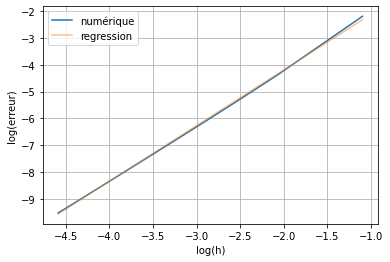

In [156]:
log_hs = np.log(hs)
log_erreurs = np.log(erreurs)

# affichage des erreurs
plt.plot(log_hs, log_erreurs, label="numérique")

# regression linéaire
coeffs = np.polyfit(log_hs, log_erreurs, 1)
reg = np.poly1d(coeffs)

# affichage de la regression linéaire
plt.plot(log_hs, reg(log_hs), alpha=0.5, label="regression")
plt.xlabel("log(h)")
plt.ylabel("log(erreur)")
plt.grid()
plt.legend()

print(f"regression linéaire: {reg}")

On observe alors que l'on obtient un ordre de discrétisation d'environ 2.

### Résolution du système linéaire par une méthode directe


In [157]:
zeros_A = []
zeros_L = []
range_n = range(3, 100, 5)

for n in range_n:
    print(f"{n}/{max(range_n)}", end="\r")
    coords, elems3, dirichlet, neumann = maillage_carre(n)

    A = assemblage(coords, elems3)

    A_tild = np.delete(A, dirichlet, 0)
    A_tild = np.delete(A_tild, dirichlet, 1)

    L = np.linalg.cholesky(A_tild)

    zeros_A.append(len(np.where(A == 0)[0]))
    zeros_L.append(len(np.where(L == 0)[0]))

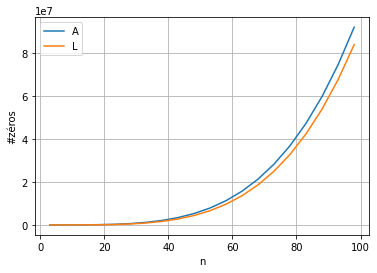

In [158]:
plt.plot(range_n, zeros_A, label="A")
plt.plot(range_n, zeros_L, label="L")
plt.xlabel("n")
plt.ylabel("#zéros")
plt.grid()
plt.legend()

On observe que la matrice L possède moins de zeros que la matrice A, il n'est donc pas bénéfique de l'utiliser pour gagner en espace mémoire lors d'un stockage creux (surtout pour n très grand).